## Inititalize

Run install_libraries notebook first.

General

In [1]:
import pandas as pd
import numpy as np
from dask.distributed import Client
from dask import delayed
# import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scipy.stats import expon
from scipy import interp

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

from util import plot_confusion_matrix as pcm
from util import evaluate, feature_selection, plot_confusion_matrix, plot_roc
from util import prec_rec_curve, feature_importance, plot_class_hist, read_data, cv, gridcv

from config import read_options
from viz import Viz
from filehandler import FileHandler

%matplotlib inline

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-u

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [ ]:
print(dask.__version__)
print(pd.__version__)

In [3]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 25 Cores: 50 Memory: 214.75 GB


In [ ]:
client.restart()

In [4]:
#fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
#viz = Viz()

In [4]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

In [11]:
num_classes=3

## Loiste-JSE

### Get data

In [17]:
X_train_thin, y_train_thin, X_test_thin, y_test_thin = read_data('../data/loiste_jse_thin_train.csv', '../data/loiste_jse_all_test.csv', options_thin)
X_res_thin, y_res_thin, _, _ = read_data('../data/loiste_jse_thin_res.csv', None, options_thin)

Train data shape: (4618, 12)
Test data shape: (1540, 12)
Train data shape: (12651, 12)


In [18]:
#dfdup = pd.concat([X_train, X_test])
#assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_train_thin, X_test_thin])
assert len(dfdup[(dfdup.duplicated())]) == 0
#dfdup = pd.concat([X_res, X_test])
#assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_res_thin, X_test_thin])
assert len(dfdup[(dfdup.duplicated())]) == 0
#dfdup = pd.concat([X_train_small, X_test])
#assert len(dfdup[(dfdup.duplicated())]) == 0

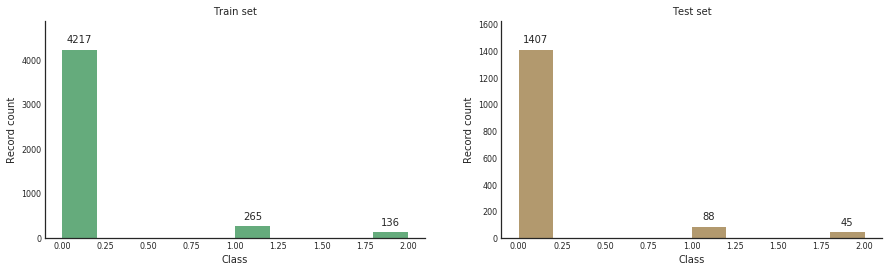

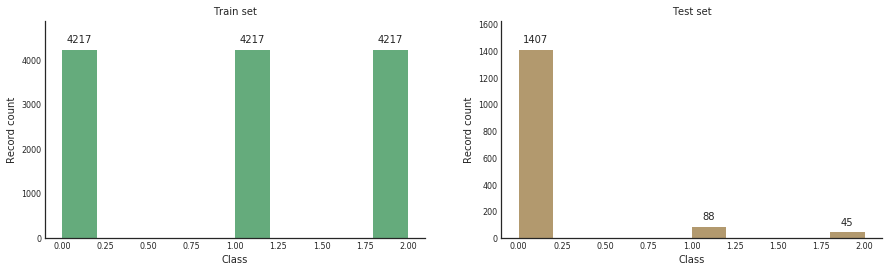

In [19]:
plot_class_hist(pd.DataFrame(y_train_thin, columns=['class']), pd.DataFrame(y_test_thin, columns=['class']))
plot_class_hist(pd.DataFrame(y_res_thin, columns=['class']), pd.DataFrame(y_test_thin, columns=['class']))

## Train

In [20]:
class_weights = []
for i in np.arange(0,1,.3):
    for j in np.arange(0, 1-i, .1):
        k = 1 - i - j 
        class_weights.append({0: i, 1: j, 2: k})

param_grid_rfc = {"n_estimators": [10, 100, 150, 200, 250, 500, 800],
                  "max_depth": [3, 10, 20, 50, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10,50],
                  "min_samples_leaf": [1, 2, 4, 10, 20],
                  "bootstrap": [True, False],
                  "class_weight": class_weights}

In [21]:
model_rfc_thin, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_train_thin, y_train_thin, 50)

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'n_estimators': 10, 'min_samples_split': 5, '...       0.340203   
1  {'n_estimators': 200, 'min_samples_split': 10,...       5.227748   
2  {'n_estimators': 800, 'min_samples_split': 2, ...      29.140438   
3  {'n_estimators': 250, 'min_samples_split': 10,...       4.558046   
4  {'n_estimators': 10, 'min_samples_split': 5, '...       0.301427   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.060643         0.010783        0.003800              0.490710   
1      0.238861         0.267777        0.030884              0.449137   
2      2.169333         0.204369        0.017837              0.391859   
3      0.469746         0.238485        0.094356              0.378805   
4      0.059514         0.012947        0.002655              0.425841   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.460381              0.503478            

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1407
           1       0.20      0.06      0.09        88
           2       0.71      0.27      0.39        45

    accuracy                           0.91      1540
   macro avg       0.61      0.44      0.48      1540
weighted avg       0.88      0.91      0.89      1540

Average precision score, micro-averaged over all classes: 0.95
AUC for class 0 is 0.8148195649037306
AUC for class 1 is 0.7218335211620337
AUC for class 2 is 0.8873727238944631


<Figure size 432x288 with 0 Axes>

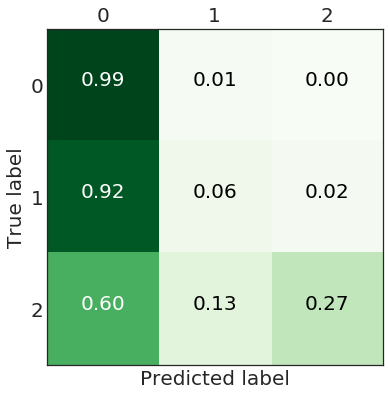

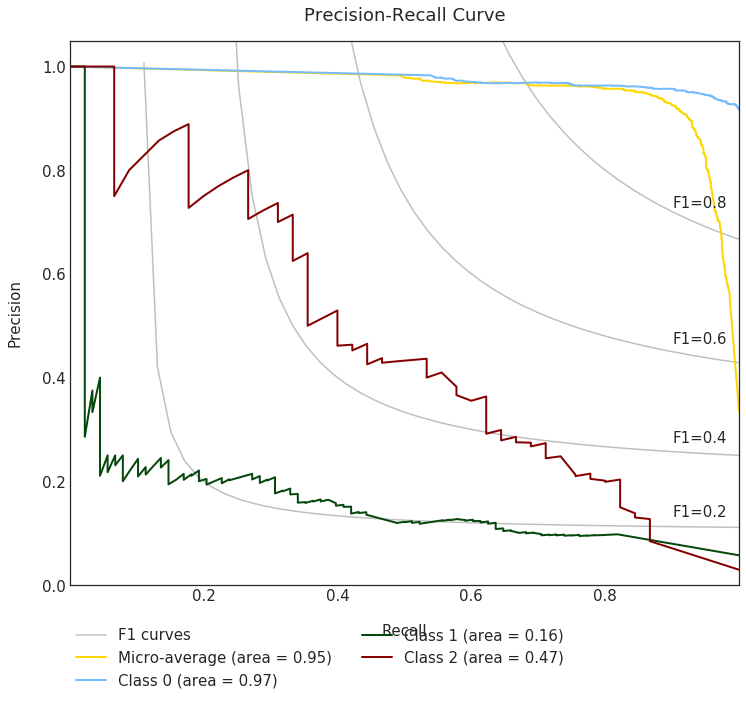

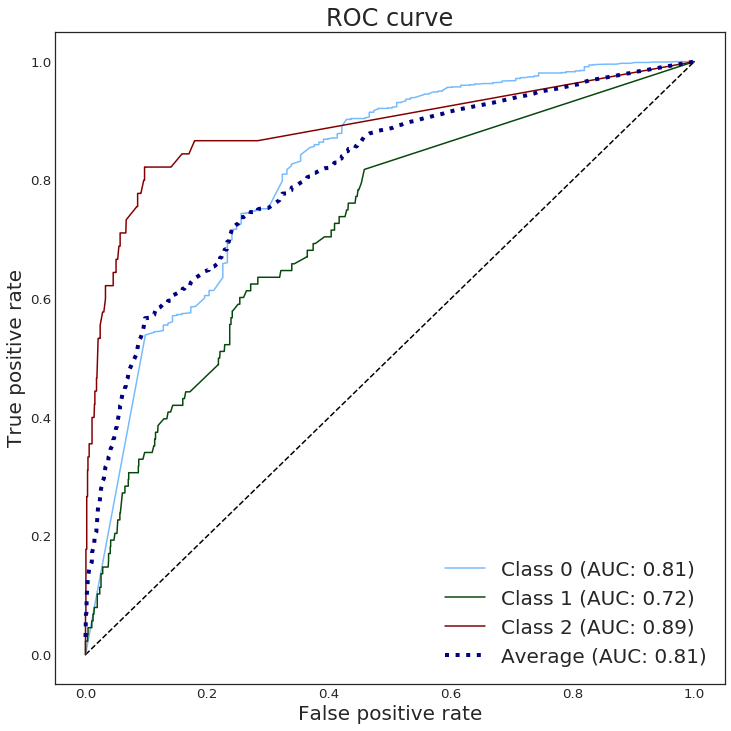

In [16]:
y_pred_proba = model_rfc_thin.predict_proba(X_test_thin.values)
y_pred = np.argmax(y_pred_proba, axis=1)

plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)
prec_rec_curve(y_test_thin, y_pred_proba, num_classes, fontsize=15)
plot_roc(y_test_thin, y_pred_proba, num_classes)

In [ ]:
params = {
    'n_estimators': 100, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'max_features': 'log2', 
    'max_depth': None, 
    'class_weight': {0: 0.01, 1: 0.02, 2: 0.03, 3: 0.9}, 
    'bootstrap': False,
    'n_jobs': -1
    }
rfc_man = RandomForestClassifier(**params).fit(X_train_thin, y_train_thin)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1521
           1       0.44      0.11      0.18        97
           2       0.69      0.25      0.37        44
           3       0.00      0.00      0.00         8

    accuracy                           0.92      1670
   macro avg       0.51      0.34      0.38      1670
weighted avg       0.89      0.92      0.89      1670

Average precision score, micro-averaged over all classes: 0.96
AUC for class 0 is 0.8668374303376886
AUC for class 1 is 0.7898132795040012
AUC for class 2 is 0.900250195683775
AUC for class 3 is 0.8600706979542719


<Figure size 432x288 with 0 Axes>

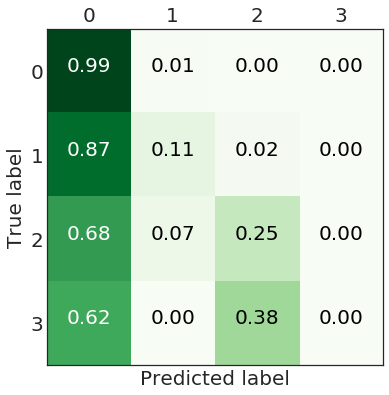

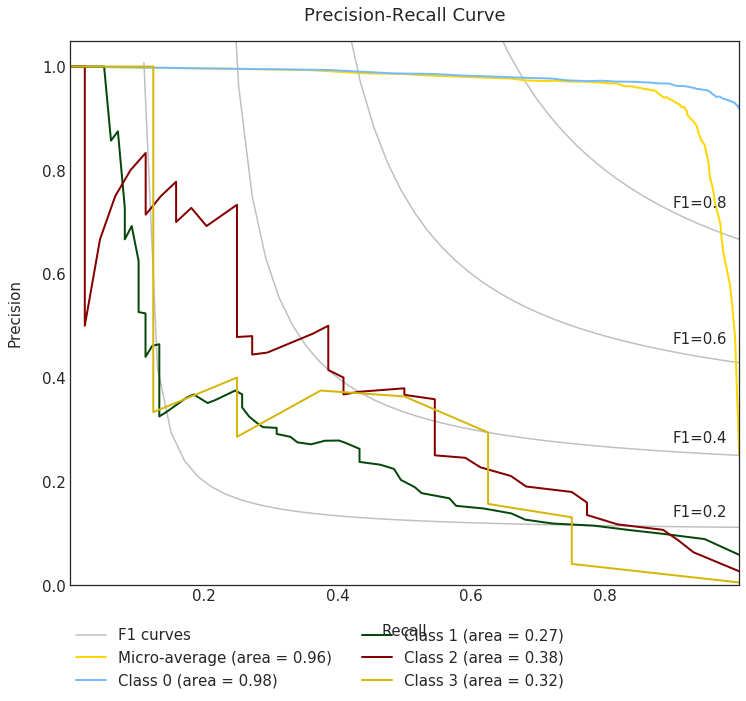

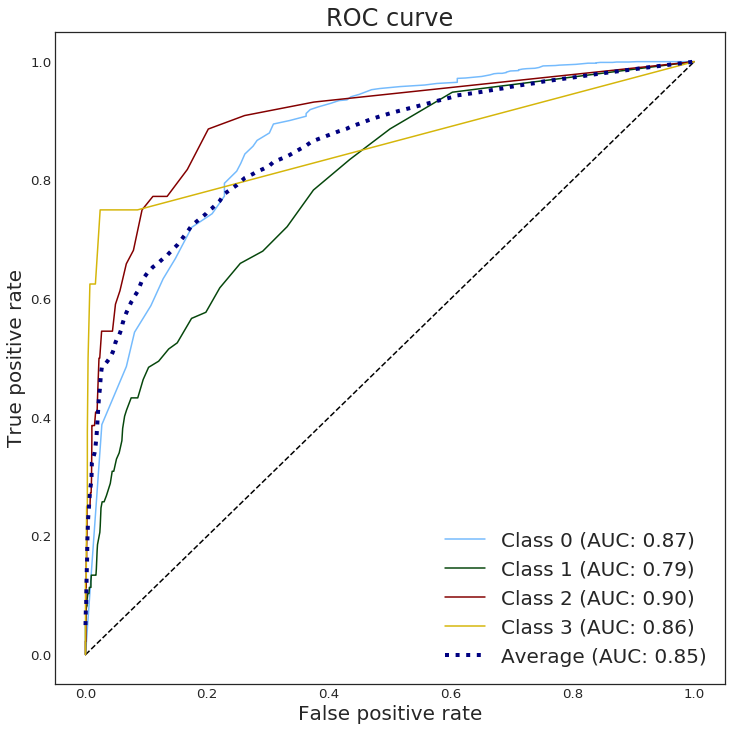

In [31]:
y_pred_proba = rfc_man.predict_proba(X_test_thin.values)
y_pred = np.argmax(y_pred_proba, axis=1)

plot_confusion_matrix(y_test_thin, y_pred, range(0,4), normalize=True, cmap=plt.cm.Greens)
prec_rec_curve(y_test_thin, y_pred_proba, 4, fontsize=15)
plot_roc(y_test_thin, y_pred_proba)

## Energiateollisuus

### Get data

In [11]:
X_train_ene, y_train_ene, X_test_ene, y_test_ene = read_data('../data/energiateollisuus_small_train.csv', '../data/energiateollisuus_all_test.csv', options)

Train data shape: (4000, 58)
Test data shape: (28296, 58)


## Train

In [12]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_ene = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_ene.fit(X_train_ene, y_train_ene)

<Figure size 432x288 with 0 Axes>

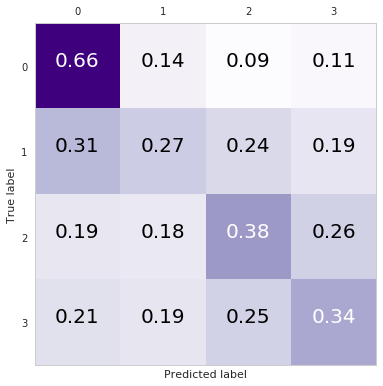

In [13]:
y_pred_proba_ene = gpc_ene.predict_proba(X_test_ene.values)
y_pred_ene = np.argmax(y_pred_proba_ene, axis=1)
plot_confusion_matrix(y_test_ene, y_pred_ene, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.67


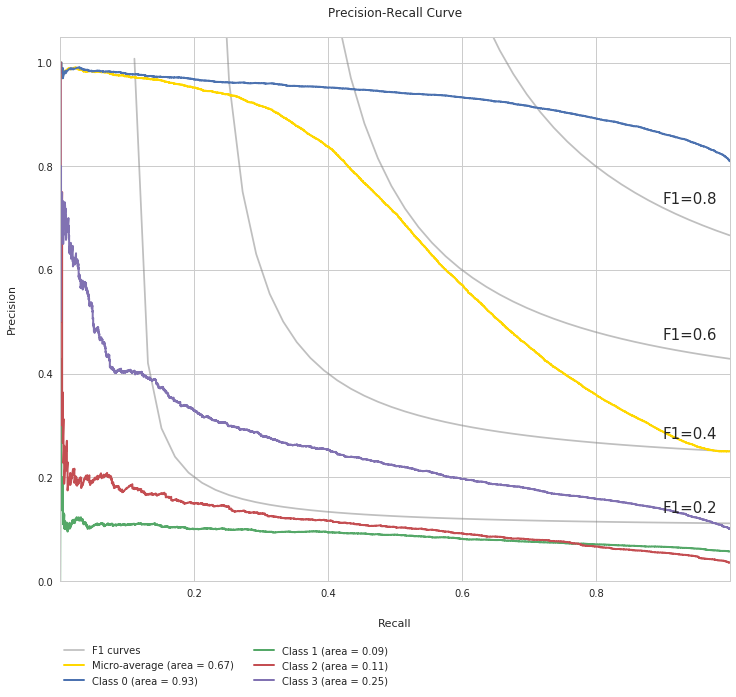

In [14]:
prec_rec_curve(y_test_ene, y_pred_proba_ene, 4, fontsize=15)

In [16]:
print(classification_report(y_test_ene, y_pred_ene))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     22895
           1       0.10      0.27      0.14      1607
           2       0.10      0.38      0.16       982
           3       0.24      0.34      0.28      2812

    accuracy                           0.60     28296
   macro avg       0.34      0.41      0.34     28296
weighted avg       0.78      0.60      0.66     28296



distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
